In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

import occlusion

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.insert(0, ROOT_DIR)
# from mrcnn.utils_occlusion import *
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model_wo_bdry as modellib
from mrcnn.model import log

from skimage.measure import find_contours
from matplotlib.patches import Polygon
from pycococreatortools.pycococreatortools import binary_mask_to_polygon

%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_PATH = r"D:\Users\ROG\Desktop\FYP\Mask_RCNN-Occulusion\logs\train_023_occ_24_raw\mask_rcnn_occlusion_0024.h5"

config = occlusion.OcclusionConfig()
dataset_DIR = '../../datasets/dataset_occluded'

correct directory imported


Using TensorFlow backend.


In [2]:
from skimage.measure import find_contours

from pycocotools import mask as maskUtils


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


def annToMask(ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(ann, height, width)
    m = maskUtils.decode(rle)
    return m


def annToRLE(ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    segm = ann
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = ann
    return rle


def mask2polygon(mask, ratio=1, concat_verts=False):
    """
    :param mask: [ROIs, height, width]
    :param ratio: point density, = 10 if choose every ten points
    :param concat_verts: if true, concat the vertices for each segmentation into
        a single list
    """
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0], mask.shape[1] + 2, mask.shape[2] + 2), dtype=np.uint8)
    padded_mask[:, 1:-1, 1:-1] = mask

    contours_flat = []  # 2n x 1
    contours_xy = []  # n x 2

    for i in range(mask.shape[0]):  # for each segmentation
        contour = find_contours(padded_mask[i, :, :], 0.5)
        xy = []  # multiple verts (in xy)
        flat = []  # multiple verts (in flat)
        for verts in contour:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            verts = verts[::ratio]  # make points less dense
            xy.append(verts.tolist())
            # flatten the 2D list
            flat.append([item for sublist in verts for item in sublist])

        contours_xy.append(xy)
        contours_flat.append(flat)
    if concat_verts:
        contours_xy = [sum(i, []) for i in contours_xy]
        contours_flat = [sum(i, []) for i in contours_flat]

    return contours_xy, contours_flat


def calc_bdry_score(polygons_true, polygons_pred):
    if len(polygons_true) != len(polygons_pred):
        raise ValueError('Different numbers of segmentations')

    N = len(polygons_true)
    bdry_score = np.ndarray((N,))
    for i in range(N):
        true = np.array(polygons_true[i])
        pred = np.array(polygons_pred[i])
        # search for the cloest point
        diff = pred[:, np.newaxis, :] - true[np.newaxis, :, :]
        all_dist = np.sqrt(np.sum(diff ** 2, axis=-1))
        min_dist = np.min(all_dist, axis=1)  # [num_points]
        bdry_score[i] = np.mean(min_dist)/len(min_dist)

    return bdry_score


## Get GT Mask

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images: 40
Classes: ['BG', 'aeroplane', 'bottle', 'bus', 'car', 'train']
image ID: occlusion.aeroplaneFGL1_BGL1/n02690373_243 (22) aeroplaneFGL1_BGL1/n02690373_243


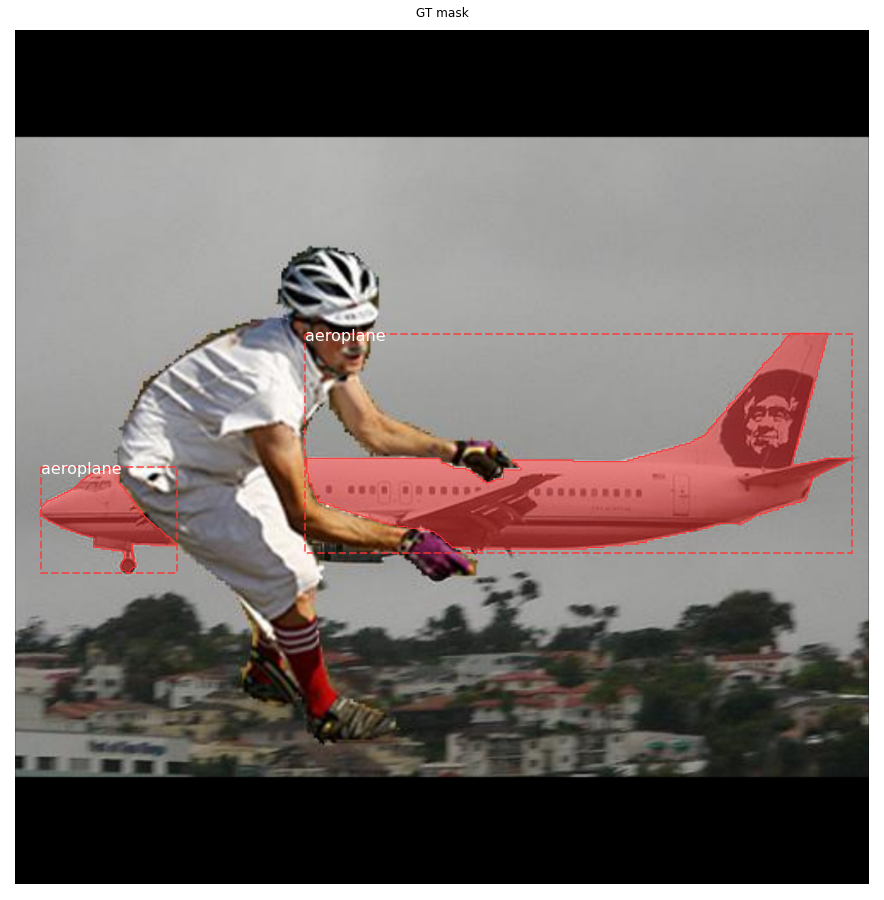

In [18]:
dataset = occlusion.OcclusionDataset()
dataset.load_occlusion(dataset_DIR, "test")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids),
                                       dataset.class_names))
# bottleFGL1_BGL1/n02823428_2278, carFGL1_BGL1/n02814533_3155
# aeroplaneFGL1_BGL1/n02690373_3378 bug
target_id = "aeroplaneFGL1_BGL1/n02690373_243"
for i in range(len(dataset.image_info)):
    if dataset.image_info[i]['id'] == target_id:
        target_idx = i
        break
image_id = target_idx
# image_id = np.random.choice(dataset.image_ids, 1)[0]

image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id,
                            dataset.class_names, title="GT mask", colors=[[1,0.2,0.2], [1,0.2,0.2]])

## Get GT Boundary

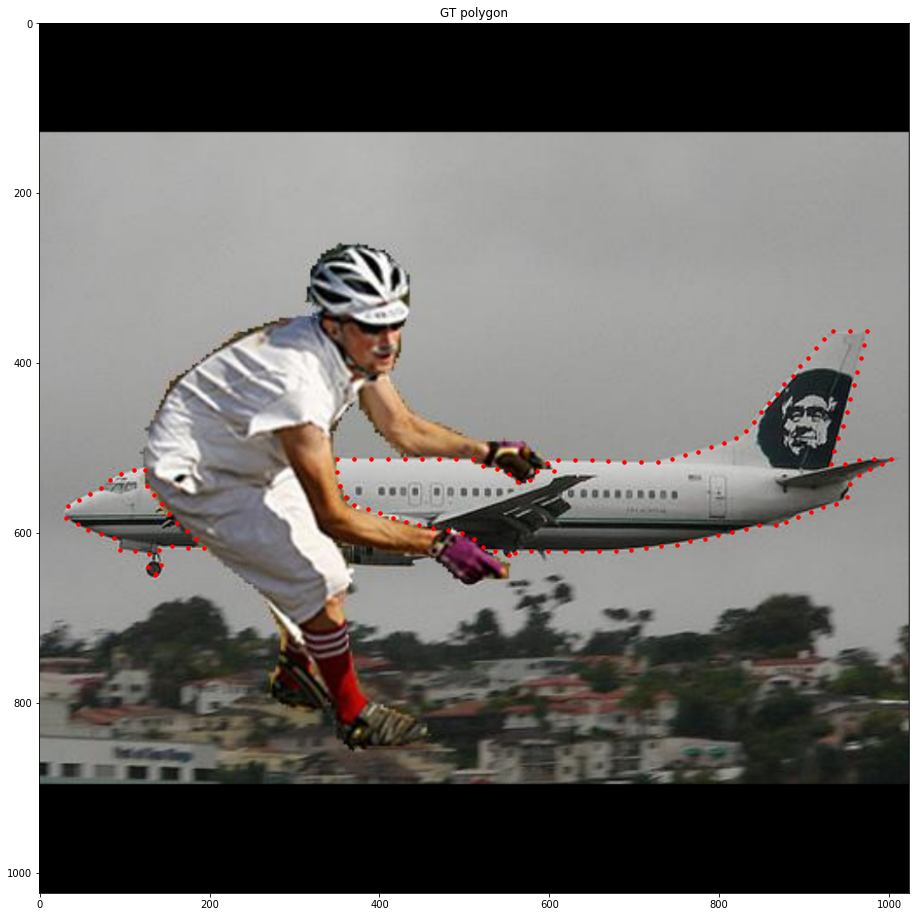

In [4]:
mask = gt_mask
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2, mask.shape[2]), dtype=np.uint8)
padded_mask[1:-1, 1:-1, :] = mask

ax = get_ax(1)
ax.set_title('GT polygon')
ax.imshow(image)
contours_flat = []  # 2n x 1
contours_xy = []  # n x 2

for i in range(mask.shape[2]):  # for each segmentation
    contour = find_contours(padded_mask[:, :, i], 0.5)
    xy = []  # multiple verts (in xy)
    flat = []  # multiple verts (in flat)
    i = 0
    for verts in contour:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        verts = verts[::20]  # make points less dense
        xy.append(verts.tolist())
        # flatten the 2D list
        flat.append([item for sublist in verts for item in sublist])
        # p = Polygon(verts, facecolor="none", linewidth=2, edgecolor='r')
        # ax.add_patch(p)
        xs, ys = zip(*verts)
        ax.scatter(xs, ys, c='r', s=12)

    contours_xy.append(xy)
    contours_flat.append(flat)

plt.show()

## Resize to 28 x 28

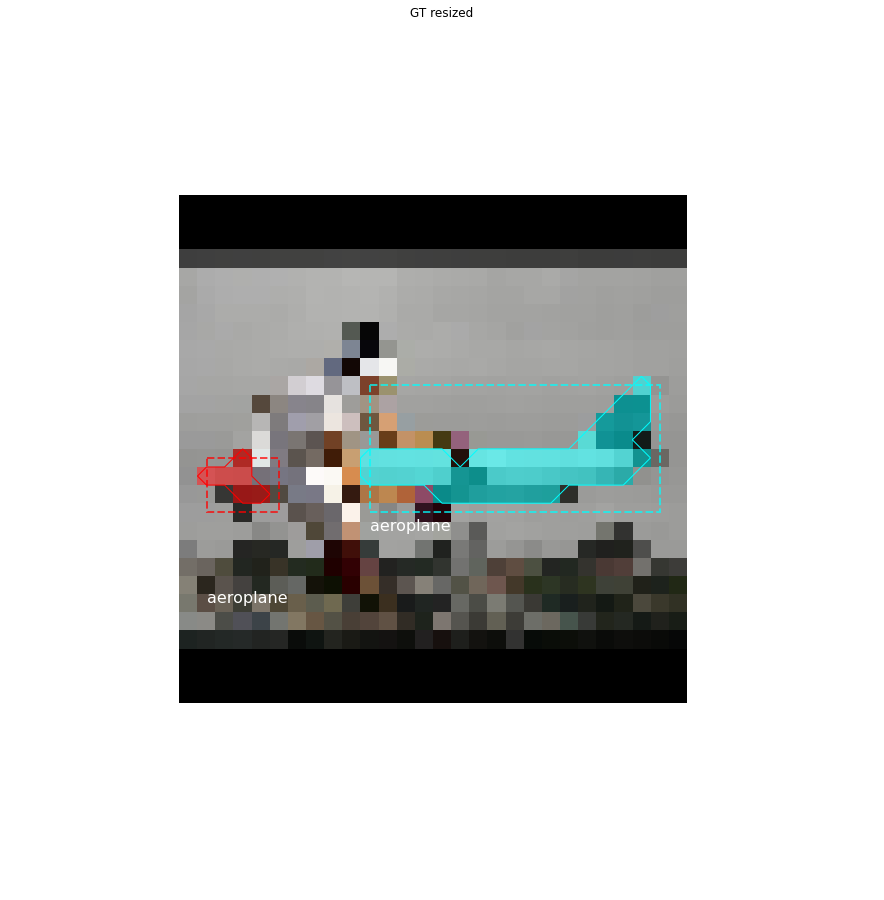

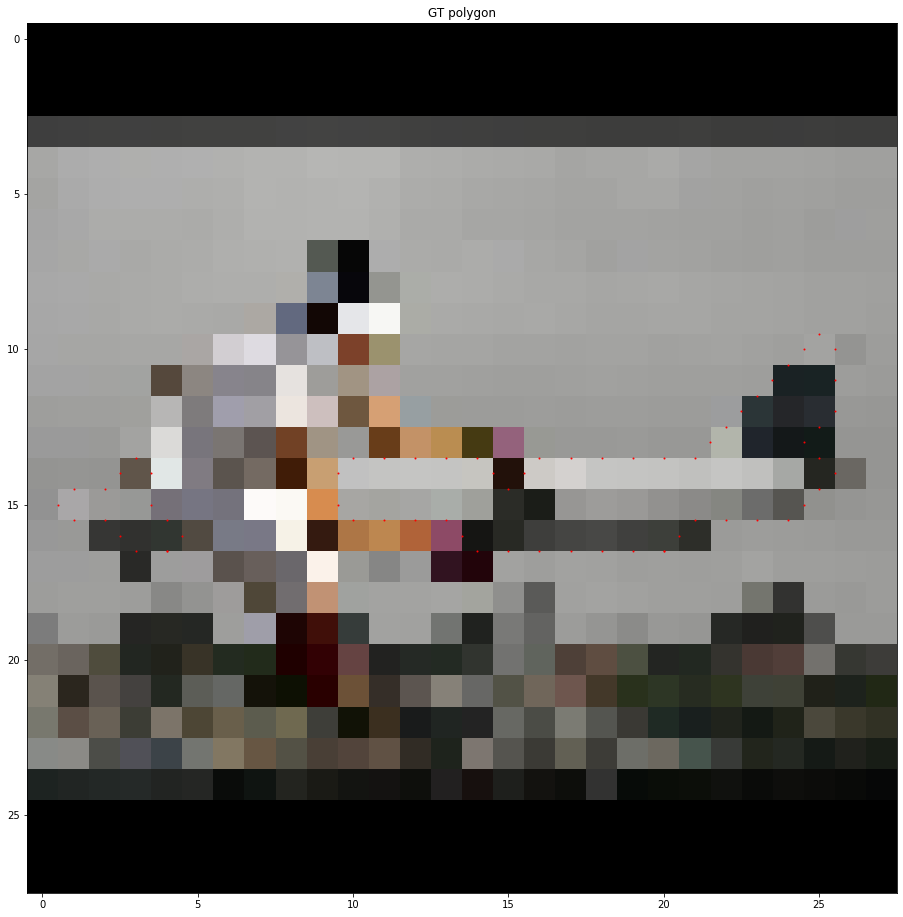

In [5]:
def demo_resize(image, mask):
    image_resized, window, scale, padding, crop = utils.resize_image(image, 28, 28)
    mask_resized = utils.resize_mask(mask, scale, padding)
    bbox_resized = utils.extract_bboxes(mask_resized)
    visualize.display_instances(image_resized, bbox_resized, mask_resized, gt_class_id,
                                dataset.class_names, title="GT resized")

    mask = mask_resized
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2, mask.shape[2]), dtype=np.uint8)
    padded_mask[1:-1, 1:-1, :] = mask

    ax = get_ax(1)
    ax.set_title('GT polygon')
    ax.imshow(image_resized)
    contours_flat = []  # 2n x 1
    contours_xy = []  # n x 2

    for i in range(mask.shape[2]):  # for each segmentation
        contour = find_contours(padded_mask[:, :, i], 0.5)
        xy = []  # multiple verts (in xy)
        flat = []  # multiple verts (in flat)
        i = 0
        for verts in contour:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
    #         verts = verts[::10]  # make points less dense
            xy.append(verts.tolist())
            # flatten the 2D list
            flat.append([item for sublist in verts for item in sublist])
            # p = Polygon(verts, facecolor="none", linewidth=2, edgecolor='r')
            # ax.add_patch(p)
            xs, ys = zip(*verts)
            ax.scatter(xs, ys, c='r', s=1)

        contours_xy.append(xy)
        contours_flat.append(flat)

    plt.show()
    
demo_resize(image, mask)

In [6]:
# # another method by using function in pycocotools, but generated points not enough
# ax = get_ax(1)
# ax.imshow(image)
# contours_flat2 = []  # 2n x 1
# contours_xy2 = []  # n x 2

# for i in range(mask.shape[2]):
#     flat2 = binary_mask_to_polygon(padded_mask[:, :, i], tolerance=2)
#     flat2 = [[x - 1 for x in sublist] for sublist in flat2]
#     contours_flat2.append(flat2)
#     xy = []
#     for verts in flat2:
#         verts = np.array(verts).reshape(-1, 2).tolist()
#         xy.append(verts)
#         xs, ys = zip(*verts)
#         ax.scatter(xs, ys, c='r')
#     contours_xy2.append(xy)

# plt.show()

## convert back to binary to check if any loss in accuracy

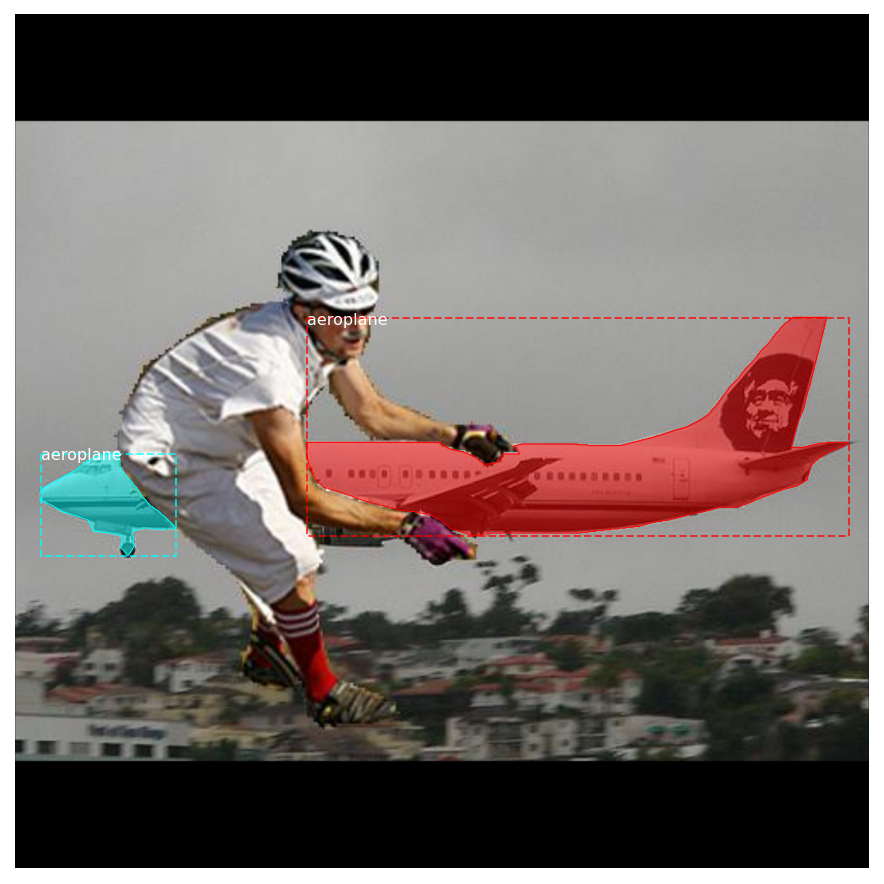

In [7]:
mask_check = []
for i in range(len(contours_xy)):  # for each annotation
    seg = contours_flat[i]
    if len(seg) == 1:  # simple case
        binary_mask = annToMask(seg, image.shape[0], image.shape[1])
    else:  # the mask contains 'holes' overlayyed in the middle
        outer_edge_poly = seg[0]
        mask_outer = annToMask([outer_edge_poly], image.shape[0], image.shape[1])
        inner_edge_poly = seg[1:]  # holes to be subtracted
        masks_inner = []
        for inner in inner_edge_poly:
            masks_inner.append(annToMask([inner], image.shape[0], image.shape[1]))
        # find their union
        union_inner = np.logical_or.reduce(masks_inner)
        # subtract the inner masks
        binary_mask = np.logical_and(mask_outer, np.logical_not(union_inner))
    mask_check.append(binary_mask)

mask_check = np.transpose(mask_check, (1, 2, 0))  # 2 x height x width to height x width x 2
_, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox_check = utils.extract_bboxes(mask_check)

visualize.display_instances(image, bbox_check, mask_check, class_ids, dataset.class_names)

## Run detection

In [8]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [9]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                          config=config)

# Set weights file path
weights_path = MODEL_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  D:\Users\ROG\Desktop\FYP\Mask_RCNN-Occulusion\logs\train_023_occ_24_raw\mask_rcnn_occlusion_0024.h5








Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   30.00000  max: 1004.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


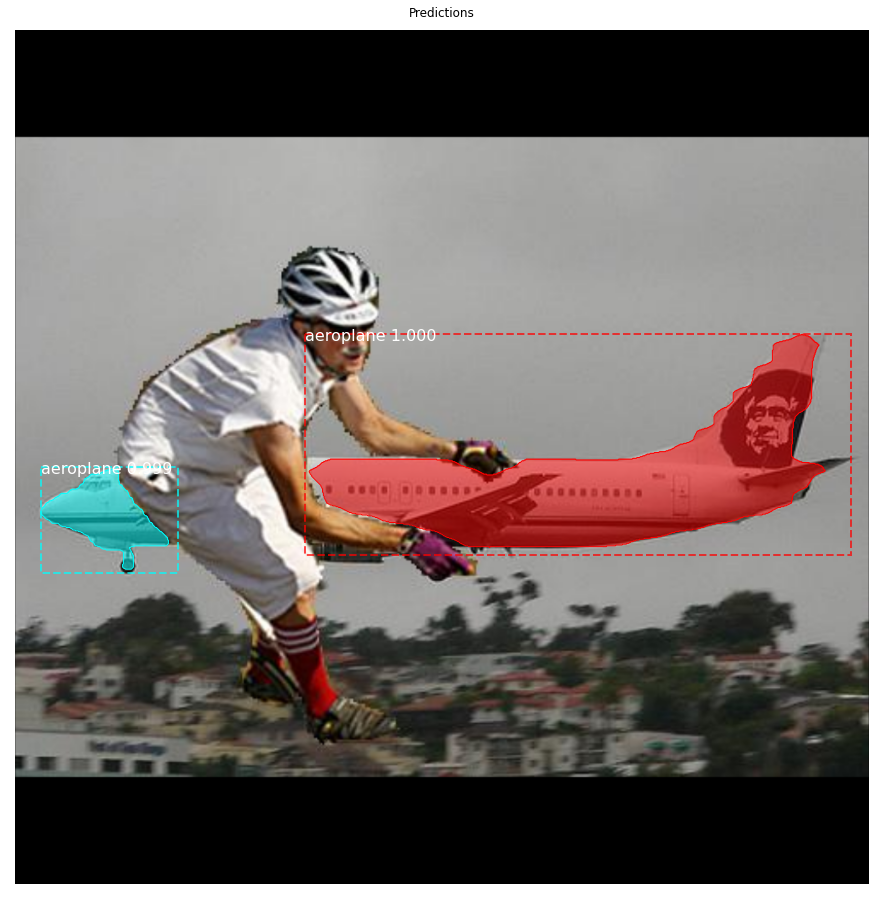

In [10]:
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

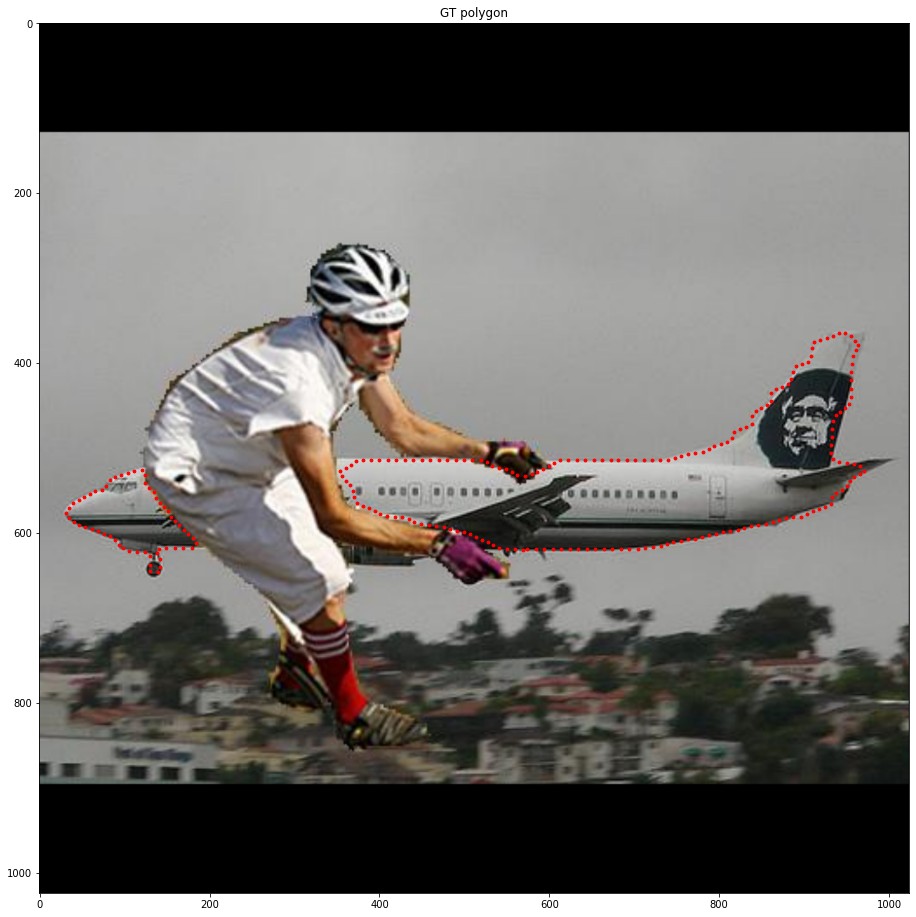

In [11]:
# convert to polygon

mask = r['masks']
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2, mask.shape[2]), dtype=np.uint8)
padded_mask[1:-1, 1:-1, :] = mask

ax = get_ax(1)
ax.set_title('GT polygon')
ax.imshow(image)
contours_flat = []  # 2n x 1
contours_xy = []  # n x 2

for i in range(mask.shape[2]):  # for each segmentation
    contour = find_contours(padded_mask[:, :, i], 0.5)
    xy = []  # multiple verts (in xy)
    flat = []  # multiple verts (in flat)
    i = 0
    for verts in contour:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        verts = verts[::10]  # make points less dense
        xy.append(verts.tolist())
        # flatten the 2D list
        flat.append([item for sublist in verts for item in sublist])
        # p = Polygon(verts, facecolor="none", linewidth=2, edgecolor='r')
        # ax.add_patch(p)
        xs, ys = zip(*verts)
        ax.scatter(xs, ys, c='r', s=8)

    contours_xy.append(xy)
    contours_flat.append(flat)

plt.show()

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min: -2055.24658  max: 2056.58447  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (61,)                 min:    0.00000  max: 1078.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


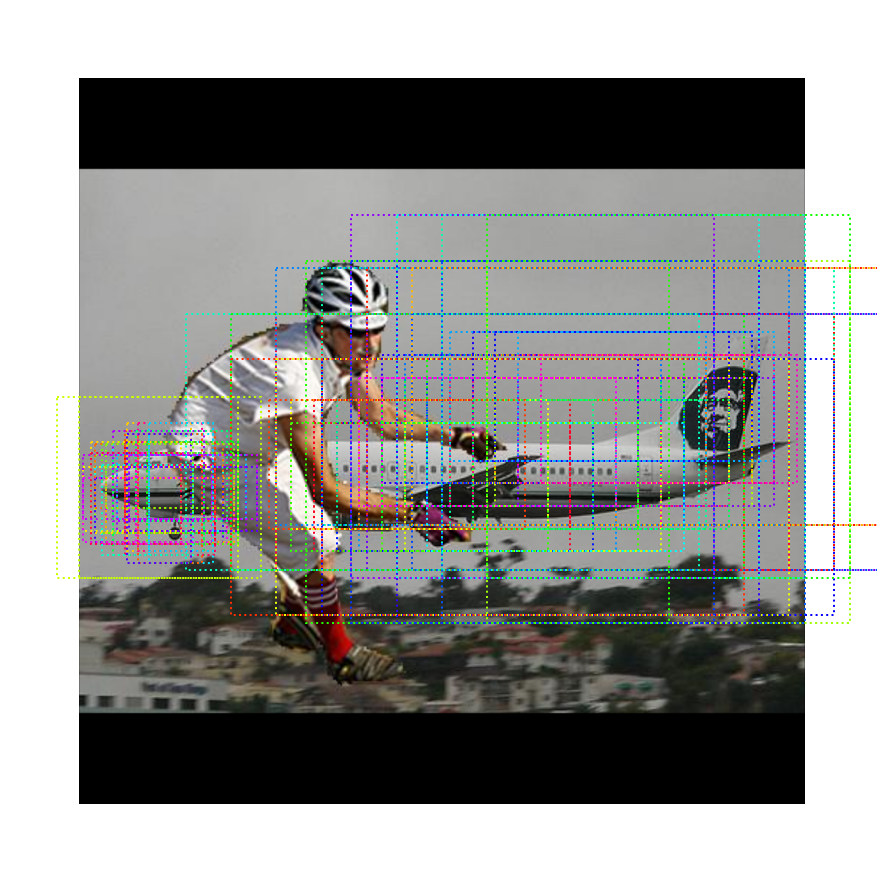

In [12]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())